In [1]:
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220530_00 import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220530_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220530_00", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)

    aucs_list.append(aucs)
    max_aucs.append(max_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7928503279117048, 0.791868104648499, 0.7923001662109358, 0.791824979478496, 0.792069572192844, 0.7923875331578779, 0.7931481737248065, 0.792233292509857, 0.7920373666718272, 0.7927580263463422]
max_auc_mean: 0.7923477542853191, max_auc_std: 0.0004189995458953528
max_auc_dir: 07


In [6]:
test_dataset[16]

(array([28, 28, 35, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  0,  0,
         0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9]),
 array([1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [66]:
# 3등급 전처리: 0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 19, 21, 100, 101
# basis = 1.0: 0, 2, 4, 6, 7
# basis = 0.5: 0, 2, 3, 7
# 임의 전처리 01: 0, 2, 100
# 임의 전처리 02: 0, 3, 4, 5, 19
# 임의 전처리 03: 5, 9, 16, 19, 28, 100
c_seq, d_seq, r_seq = test_dataset[19]

c_seq, cshft_seq, d_seq, dshft_seq, r_seq, rshft_seq = \
[c_seq[:-1]], [c_seq[1:]], [d_seq[:-1]], [d_seq[1:]], [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 5

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

alpha_seq, h_seq, C_seq = model(
    LongTensor(c_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)

# c_one_hot_seq: [batch_size, seq_len, 1, num_c]
c_one_hot_seq = one_hot(LongTensor(c_seq), model.num_c).float()
c_one_hot_seq = torch.reshape(
    c_one_hot_seq,
    shape=[
        -1,
        c_one_hot_seq.shape[1],
        c_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta_seq = torch.bmm(
    torch.reshape(
        c_one_hot_seq,
        shape=[
            -1,
            c_one_hot_seq.shape[2],
            c_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C_seq, shape=[-1, C_seq.shape[2], C_seq.shape[3]]
    )
)
beta_seq = torch.reshape(
    beta_seq, shape=[1, seq_len]
)

gamma_seq = model.D(LongTensor(d_seq)).squeeze()
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

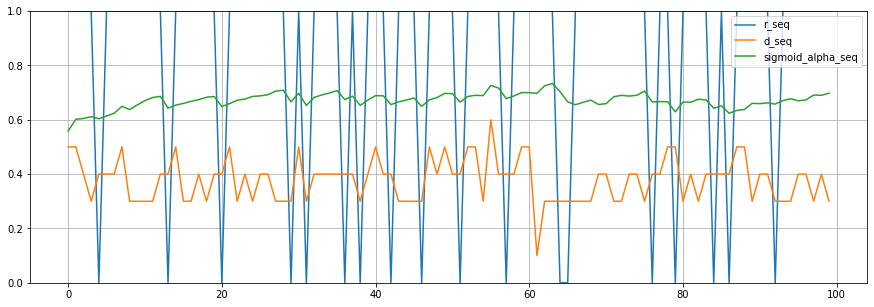

In [67]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
# plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

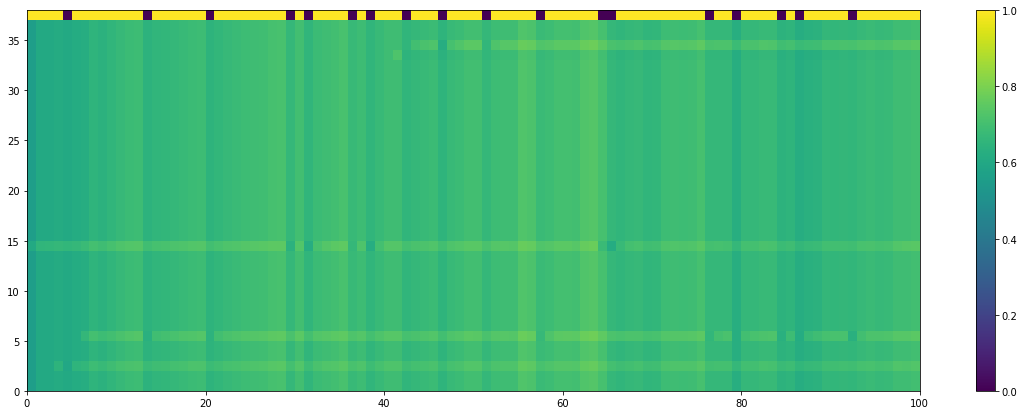

In [68]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [69]:
CQ_seq[0], CQ_seq[-1], c_seq, d_seq

(array([0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.60241807,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934, 0.55810934, 0.55810934, 0.55810934,
        0.55810934, 0.55810934], dtype=float32),
 array([0.6976231 , 0.6976231 , 0.7293364 , 0.6976231 , 0.6976231 ,
        0.74283344, 0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 ,
        0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 , 0.7392673 ,
        0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 ,
        0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 ,
        0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 , 0.6976231 ,
        0.6976231 , 0.6976231 , 0.6976231 , 0.6896806 , 0.74371165,

In [11]:
model.D.weight

Parameter containing:
tensor([[-0.7554],
        [-0.5619],
        [-0.2448],
        [ 0.2410],
        [ 0.6294],
        [ 0.7922],
        [ 1.7171]], requires_grad=True)